# A. Import data, EDA, Manipulation

## A.1 Import and merge

### A.1.1 Import libraries

In [13]:
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### A.1.2.1 Set file path for main folder and DTA files folder

In [14]:
path = os.getcwd() #Main folder
files_folder = path+'/hh02dta_bc' #DTA files

## A.2 Calculating consumption

### A.2.1 Weekly variables

### A.2.1.1 Import weekly variables data "i_cs"

In [15]:
df1 = pd.read_stata(path+'/hh02dta_b1/i_cs.dta')
df1 = df1.rename(columns={'folio':'Household_id'})

### A.2.1.2 Select weekly consumption variables

In [16]:
#df1.filter(regex='cs02a_', axis=1)
cons1 = [i for i in df1.columns if i.startswith('cs02a_') and i.endswith('2')]
cons1.append('Household_id')
cons1 = df1[cons1]
cons1.set_index('Household_id', inplace=True)

#### A.2.1.2.1 Convert weekly varibles to monthly vars

In [17]:
cons1 = cons1*4.3

### A.2.2 Select Monthly variables
- Uses "i_cs"

In [18]:
cons2 = [i for i in df1.columns if i.startswith('cs16') and i.endswith('2')]
cons2.append('Household_id')
cons2 = df1[cons2]
cons2.set_index('Household_id', inplace=True)

### A.2.3 3-Month variables

### A.2.3.1 Import weekly variables data "i_cs1"

In [19]:
df2 = pd.read_stata(path+'/hh02dta_b1/i_cs1.dta')
df2 = df2.rename(columns={'folio':'Household_id' })

### A.2.3.2 Select 3-month variables

In [20]:
cons3 = [i for i in df2.columns if i.startswith('cs22') and i.endswith('2')]
cons3.append('Household_id')
cons3 = df2[cons3]
cons3.set_index('Household_id', inplace=True)

### A.3.3 Convert 3-month varibles to monthly vars

In [21]:
cons3 = cons3/3

### A.2.4 Merge consumption variables into one dataframe

In [22]:
cons_merge = pd.concat([cons1, cons2, cons3], axis=1)
#cons_merge.to_csv('consu_Python.csv')

# Homework Questions

## Q.1. 
- Calculate a measure of total consumption and per capita consumption for each household in the 2002 round. 
    - To calculate per capita note you will have to calculate the number of individuals in each household.

## Q.1.1 Total consumption

### 1.1.1 Calculate total consumer spending
- Sum the rows from cons_merge (A.2.4)

In [23]:
cons_merge['total_cons'] = cons_merge.sum(axis=1)

In [24]:
sum(round(cons_merge.iloc[0,:-1],3))==round(cons_merge.iloc[0,-1],3)

True

#### 1.1.1.1 Basic stats: total consumer spending

In [26]:
cons_merge['total_cons'].describe()

count    8.052000e+03
mean     2.050501e+03
std      1.822217e+04
min      0.000000e+00
25%      5.951750e+02
50%      1.118767e+03
75%      2.001467e+03
max      1.450983e+06
Name: total_cons, dtype: float64

#### 1.1.1.2 Graph: total consumer spending

In [27]:
from scipy import stats
#Calculates Z-scores
z = np.abs(stats.zscore(cons_merge['total_cons']))
threshold = 3
print('Outlier Z-scores: \n \n{}'.format(np.where(z > threshold)[:5]))

Outlier Z-scores: 
 
(array([3306, 3454, 4899, 5564, 6591, 6648, 7297, 7758]),)


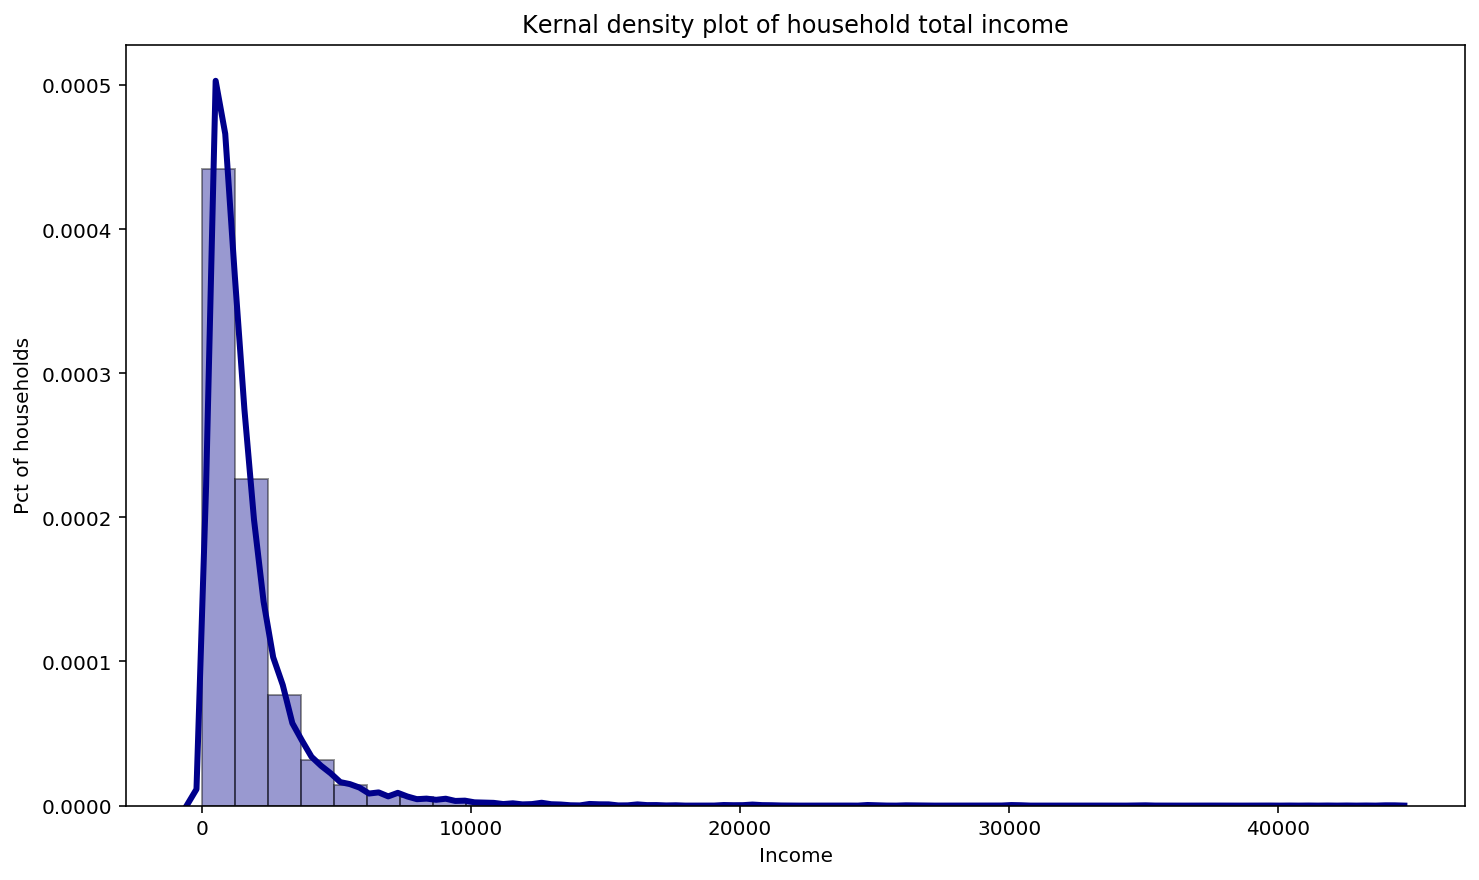

In [28]:
outlier_removed = cons_merge['total_cons'][(z < 5)].values
import seaborn as sns
ax = sns.distplot(outlier_removed, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
ax.set_xlabel('Income')
ax.set_ylabel('Pct of households')
ax.set_title('Kernal density plot of household total income')
plt.show()

## Q.1.2 Per capita consumption (Total/house size)

### 1.2.1 Avg. house size

#### 1.2.1.1 Import house size data set "c_ls"

In [76]:
df_housesize = pd.read_stata(path+'/hh02dta_bc/c_ls.dta')
df_housesize = df_housesize.rename(columns={'folio':'Household_id'})
df_housesize.set_index('Household_id', inplace=True)
merge = pd.merge(df_housesize, cons_merge, left_index=True, right_index=True)

#### 1.2.1.2 Count family members "ls" in each household "folio"

In [77]:
merge['family_members'] = merge.groupby(merge.index.get_level_values(0))['ls'].count()
merge.family_members.head(5)

Household_id
1000.0    4
1000.0    4
1000.0    4
1000.0    4
2000.0    5
Name: family_members, dtype: int64

#### 1.2.1.2 Family members graph

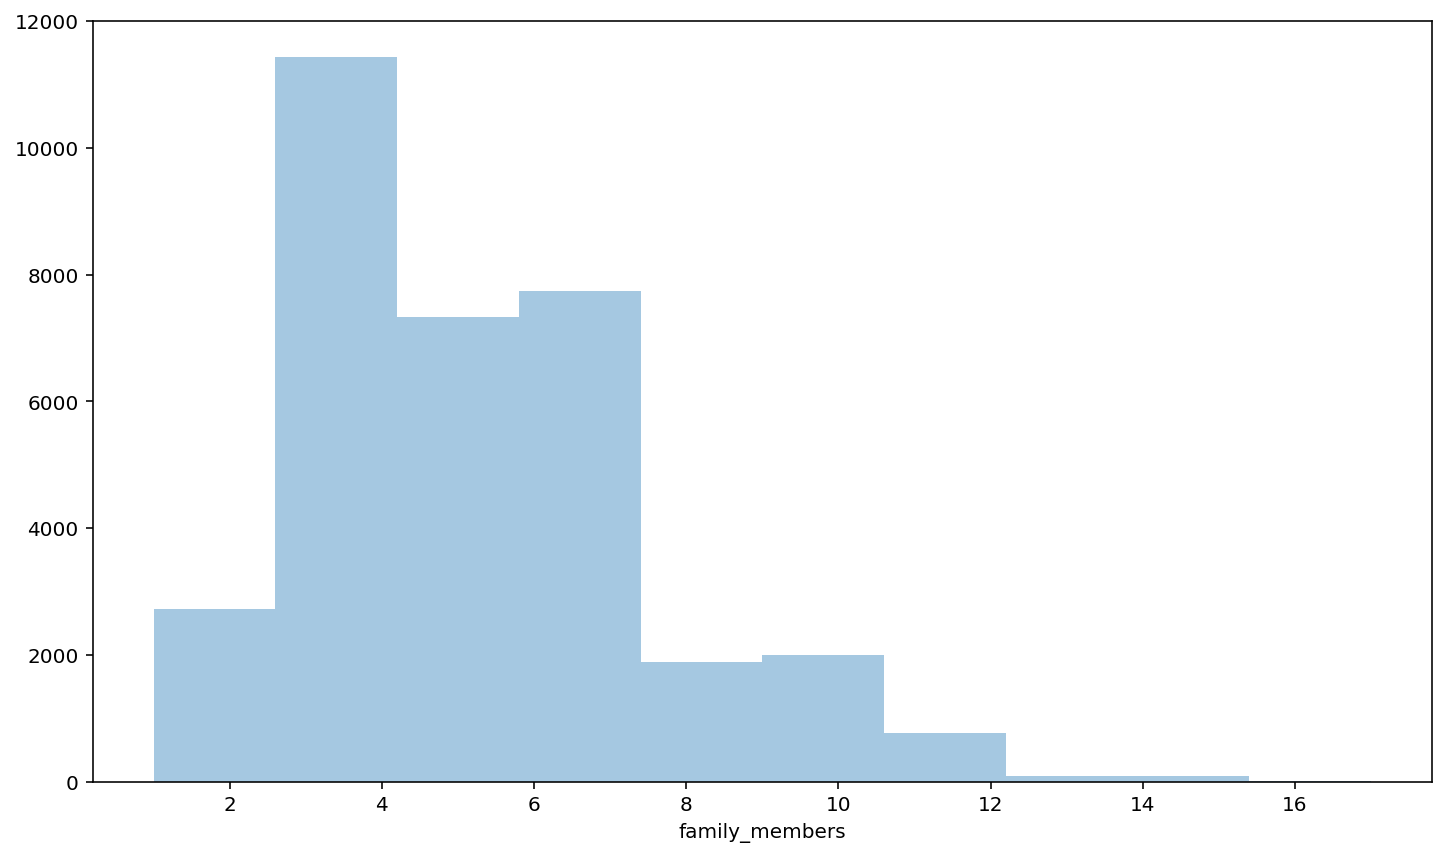

In [78]:
sns.distplot(merge['family_members'], kde=False, bins=10)

## 1.3 Per capita consumption (Total/house size)

### 1.3.1 Merge family_members and consumption data set

#### 1.3.1.1 Check to see if df are the same length

#### 1.3.1.2 Merge two data sets and drop na values

#### 1.3.1.3 Calculate percapita consumption

In [79]:
merge['percap_consum'] = (merge.total_cons)/(merge.family_members)

In [80]:
merge[['family_members','total_cons', 'percap_consum']].head(5)

,family_members,total_cons,percap_consum
Household_id,,,
1000.0,4,1876.866664,469.216666
1000.0,4,1876.866664,469.216666
1000.0,4,1876.866664,469.216666
1000.0,4,1876.866664,469.216666
2000.0,5,5464.533420,1092.906684


#### 1.3.1.4 Percap consumption summary

In [81]:
round(merge[['family_members','total_cons', 'percap_consum']].describe())

,family_members,total_cons,percap_consum
count,34063.0,34063.0,34063.0
mean,5.0,2191.0,485.0
std,2.0,22120.0,3725.0
min,1.0,0.0,0.0
25%,4.0,646.0,129.0
50%,5.0,1178.0,245.0
75%,6.0,2094.0,465.0
max,17.0,1450983.0,207283.0


# Q.2. 

- Calculate the set of poverty rates nationwide using the FGT indicators of poverty:
    - Head count
    - Average poverty gap
    - Average poverty gap squared. 
- Assume the poverty line=500 pesos per person. Provide poverty rates based on household consumption per capita.



## 2.1 Headcount using 1000 as an example

In [82]:
povertyline = 500
merge['below_poverty_dummy'] = merge.percap_consum< int(povertyline)
#merge['below_poverty_dummy'] = lambda: merge['percap_consum']<500
#merge['below_poverty_dummy'].apply(lambda val: 1 if merge.percap_consum < 1000 else 0)
#merge['below_poverty_dummy'] = (merge.percap_consum > int(povertyline)).astype('int')
merge[['family_members','total_cons', 'percap_consum', 'below_poverty_dummy']].head(4)

,family_members,total_cons,percap_consum,below_poverty_dummy
Household_id,,,,
1000.0,4,1876.866664,469.216666,True
1000.0,4,1876.866664,469.216666,True
1000.0,4,1876.866664,469.216666,True
1000.0,4,1876.866664,469.216666,True


In [83]:
head_count = merge['below_poverty_dummy'].mean()
print('Headcount: {}'.format(head_count))

Headcount: 0.7748877080703402


## 2.2 Avg. poverty gap

In [84]:
((povertyline-merge['percap_consum'])*merge['below_poverty_dummy']).mean()

225.770804147384

## 2.3 Avg. poverty gap squared

In [85]:
(((povertyline-merge['percap_consum'])*merge['below_poverty_dummy'])**2).mean()

77799.84883842707

## Q.3 Repeat 2) by area of residence.

- How does the poverty rate change by rural/urban residence?

## 3.1. Import residence data from "c_portad"

In [86]:
residence_df = pd.read_stata(path+'/hh02dta_bc/c_portad.dta')
residence_df  = residence_df.rename(columns={'folio':'Household_id'})
residence_df.set_index('Household_id', inplace=True)

### 3.1.1. Merge residence df with percap_consum df from Q.1 & Q.2 

In [87]:
consum_residence_df  = pd.merge(residence_df, merge, left_index=True, right_index=True)

#### 3.1.1.2 Create poverty dummy

In [88]:
#Created previously
consum_residence_df['below_poverty_dummy'].head(2)

Household_id
1000.0    True
1000.0    True
Name: below_poverty_dummy, dtype: bool

## 3.2 Show poverty by area of residence

In [89]:
consum_residence_df.groupby('estrato')['below_poverty_dummy'].mean()

estrato
1.0    0.663626
2.0    0.662379
3.0    0.820966
4.0    0.884178
Name: below_poverty_dummy, dtype: float64

# Q.4. 

Calculate the Gini coefficient overall and by urban and rural areas both using consumption measures. In both R and Stata there are programs which can be downloaded to calculate the Gini. Provide a graph of the Lorenz curve.

## 4.1 Calculate cumulative sum for population and consumption

In [90]:
var_list = ['percap_consum', 'family_members']
for i in var_list:
    consum_residence_df[str(i)+'_cumulative'] = consum_residence_df[str(i)].cumsum()
    consum_residence_df[str(i)+'_cumulative_pct'] = consum_residence_df[str(i)+'_cumulative']/sum(consum_residence_df[str(i)])

In [91]:
consum_residence_df.iloc[:,-4:].tail(3)

,percap_consum_cumulative,percap_consum_cumulative_pct,family_members_cumulative,family_members_cumulative_pct
Household_id,,,,
10758000.0,1.650842e+07,0.999976,177619,0.999977
10759000.0,1.650861e+07,0.999988,177621,0.999989
10759000.0,1.650881e+07,1.000000,177623,1.000000


### 4.1.1 Plot:

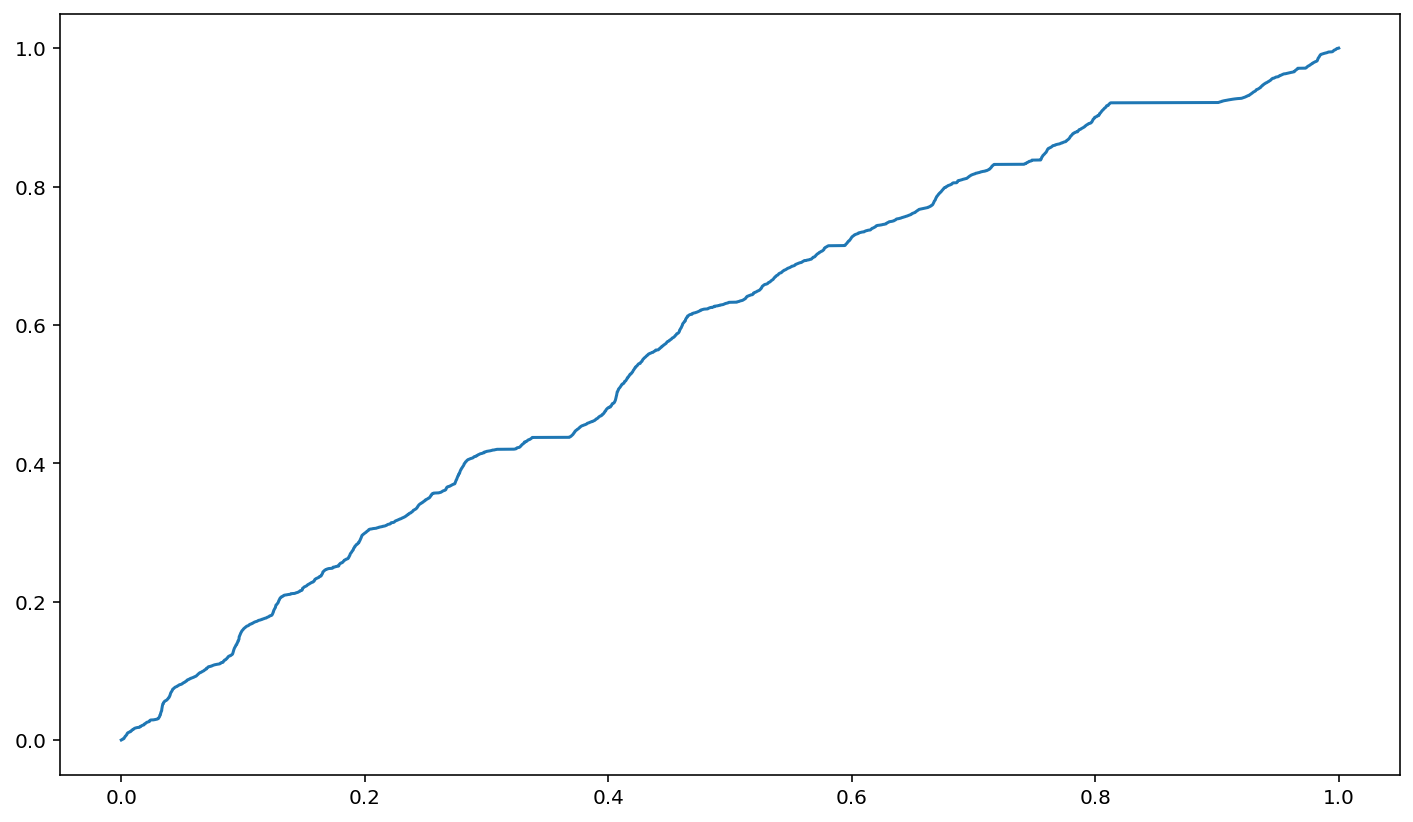

In [92]:
plt.plot(consum_residence_df['percap_consum_cumulative_pct'],consum_residence_df['family_members_cumulative_pct'])

## Gini coefficient calculation

In [93]:
cov_consum_V_consum_pct = consum_residence_df[['percap_consum','percap_consum_cumulative_pct']].cov().iloc[0,1:]
mean_cons = np.mean(consum_residence_df['percap_consum'])
print((2*cov_consum_V_consum_pct)/mean_cons)

percap_consum_cumulative_pct    0.150543
Name: percap_consum, dtype: float64


# Check answers

In [75]:
consum_residence_df[['family_members','total_cons','percap_consum']].to_csv('Data_python.csv')